# 📺 TubeScope: Viral Lifecycle Analytics
### *Predicting Video Longevity using Machine Learning*

**Authors:** TubeScope Team
**Date:** November 2025

---

### 🎯 Project Goal
**TubeScope** predicts whether a trending YouTube video has the "staying power" to survive past 24 hours.

### 🔄 The Pivot: Regression $\to$ Classification
Initially, we attempted to predict the exact number of days a video would trend. However, our analysis revealed a **"24-Hour Cliff"**:
* **83%** of trending videos drop off within 1 day.
* Because the data is so heavily skewed toward 1 day, Regression models yielded poor results ($R^2 < 0$).
* **Solution:** We pivoted to a **Classification Model** to detect "Viral Potential" (Probability of surviving > 1 Day).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from lifelines import KaplanMeierFitter
import joblib


## 2️⃣ Data Loading:
Loading our Data in:

1.  **Training:** We use a historical snapshot (~10k videos) to train the model on statistically significant data.
2.  **Action:** Initial column renaming is performed to create clear, consistent feature names for the model.

Note: This dataset still contains duplicate video entries from daily snapshots, which will be addressed in the next step to prevent data leakage.

In [2]:

df = pd.read_csv("../data_processed/subset_newest_10k.csv")

# Rename for clarity
df = df.rename(columns={
    'video_id': 'video_id',
    'video_published_at': 'published_at',
    'video_trending__date': 'trending_date',
    'video_view_count': 'views',
    'video_like_count': 'likes',
    'video_comment_count': 'comments',
    'video_description': 'description',
    'video_tags': 'tags',
    'video_category_id': 'category',
    'video_duration': 'duration'
})

print(f"Loaded {len(df)} rows (with duplicates)")

Loaded 10000 rows (with duplicates)



## 3️⃣ Feature Engineering: From Raw Data to Insights
We transformed raw metadata into numerical features the model can interpret:

* **Time & Duration:** We converted complex ISO duration strings (e.g., `PT1H2M10S`) into standard **minutes** and parsed timestamps to extract `publish_hour` and `is_weekend` to detect timing patterns.
* **Content Effort:** We calculated word and character counts for titles and descriptions, as well as the number of tags. This helps distinguish between "low-effort" uploads and optimized content.
* **Trending Lifecycle:** We calculated `total_days_trending` by counting how many daily snapshots each video appeared in, which serves as the basis for our "Viral" target variable.

In [3]:
# Convert Duration to minutes
def iso_to_minutes(duration):
    if not isinstance(duration, str):
        return 0
    duration = duration.replace('PT','')
    h = m = s = 0
    if 'H' in duration:
        parts = duration.split('H')
        h = int(parts[0])
        duration = parts[1] if len(parts) > 1 else ''
    if 'M' in duration:
        parts = duration.split('M')
        m = int(parts[0])
        duration = parts[1] if len(parts) > 1 else ''
    if 'S' in duration:
        s = int(duration.replace('S',''))
    return h*60 + m + s/60

df['duration'] = df['duration'].apply(iso_to_minutes)

In [4]:
# Time-based features

df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', utc=True)
df['published_at'] = df['published_at'].dt.tz_localize(None)

df['publish_dayofweek'] = df['published_at'].dt.dayofweek
df['publish_hour'] = df['published_at'].dt.hour
df['is_weekend'] = df['publish_dayofweek'].isin([5,6]).astype(int)

In [5]:
# Text-based metrics

df['description_word_count'] = df['description'].fillna("").str.split().str.len()
df['title_word_count'] = df['video_title'].fillna("").str.split().str.len()
df['description_char_count'] = df['description'].fillna("").str.len()
df['title_char_count'] = df['video_title'].fillna("").str.len()
df['tags_count'] = df['tags'].fillna("").str.split(',').str.len()

In [6]:
# Calculate days trending per video

days_trending = df.groupby('video_id').size().rename('total_days_trending')
df = df.merge(days_trending, on='video_id', how='left')


## 🛠️ 4️⃣ Critical Data Engineering: Fixing Leakage

**The Problem:**  
Our raw data has **duplicates**. Splitting this randomly across train/test sets causes **data leakage** (the model memorizes the specific video instead of learning patterns).

**The Solution:**  
We **aggregate the data by `video_id`**. This enforces **one row per unique video** by:
- taking the **max** for the **trending duration**, and  
- taking the **first** for **static features**.

**Result:**  
✅ Data leakage is **eliminated**, ensuring a **valid model test**.


In [7]:
# Aggregate to ONE ROW PER VIDEO to prevent leakage

agg_dict = {
    'total_days_trending': 'max',
    'duration': 'first',
    'description_word_count': 'first',
    'title_word_count': 'first',
    'title_char_count': 'first',
    'tags_count': 'first',
    'publish_hour': 'first',
    'is_weekend': 'first',
    'category': 'first',
    'channel_subscriber_count': 'first',
    'channel_video_count': 'first',
    'channel_view_count': 'first',
}

df_unique = df.groupby('video_id').agg(agg_dict).reset_index()

print(f"   Before: {len(df)} rows (duplicates)")
print(f"   After:  {len(df_unique)} rows (unique videos)")
print(f"   Data leakage ELIMINATED :)")

   Before: 10000 rows (duplicates)
   After:  8249 rows (unique videos)
   Data leakage ELIMINATED :)


### 📊 Viral vs. Non-Viral Breakdown

We create a new column that labels each video as **viral** (1) or **non-viral** (0):



In [8]:
df_unique['is_viral'] = (df_unique['total_days_trending'] > 1).astype(int)

viral_percent = df_unique['is_viral'].mean() * 100

print(f"   Viral Rate: {viral_percent:.1f}%")
print(f"   Non-Viral Rate: {100-viral_percent:.1f}% (Baseline)")
print(f"   Class Balance: {df_unique['is_viral'].value_counts().to_dict()}")


   Viral Rate: 17.1%
   Non-Viral Rate: 82.9% (Baseline)
   Class Balance: {0: 6842, 1: 1407}


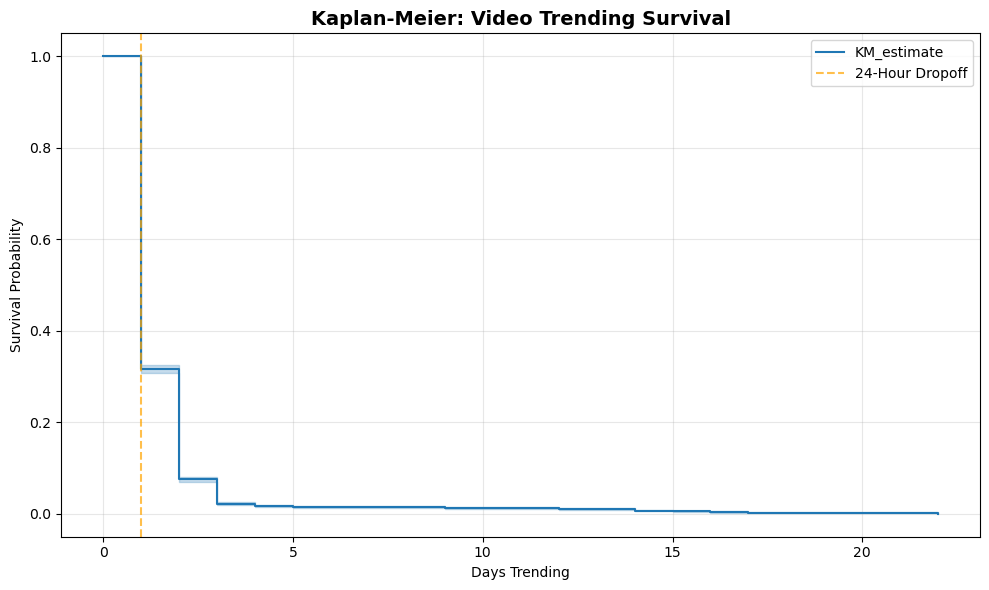

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(df['total_days_trending'], event_observed=[1]*len(df))

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier: Video Trending Survival', fontsize=14, fontweight='bold')
plt.xlabel('Days Trending')
plt.ylabel('Survival Probability')
plt.axvline(x=1, color='orange', linestyle='--', label='24-Hour Dropoff', alpha=0.7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

### Establishing the Baseline

Our analysis shows a clear split in the data:
* **Non-Viral (82.9%):** Most videos are "One-Hit Wonders" that drop off the trending list within 24 hours.
* **Viral (17.1%):** Only a small minority have the staying power to trend for multiple days.

**Why this matters:**
This establishes our **Random Baseline of 17.1%**.
If we guessed randomly, we would only find a viral video **1 out of 6 times**. Our machine learning model needs to significantly beat this 17% probability to be considered successful.

---

## 🎯 5️⃣  Feature Selection & One-Hot Encoding

We begin by selecting the columns we want to use as model features:


In [10]:
df_unique.columns

Index(['video_id', 'total_days_trending', 'duration', 'description_word_count',
       'title_word_count', 'title_char_count', 'tags_count', 'publish_hour',
       'is_weekend', 'category', 'channel_subscriber_count',
       'channel_video_count', 'channel_view_count', 'is_viral'],
      dtype='object')

In [11]:
feature_cols = [
    'channel_subscriber_count', 
    'channel_video_count',       
    'channel_view_count',        
    'duration',
    'description_word_count',
    'title_char_count',
    'tags_count',
    'publish_hour',
    'is_weekend',
    'category',  # Will be one-hot encoded
]

We then one-hot encode the `category` column so our model can process the categorical data as numerical data. We also establish our **X (features)** and **y (target)**

In [12]:
X = df_unique[feature_cols].copy()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
category_encoded = encoder.fit_transform(X[['category']])
category_cols = encoder.get_feature_names_out(['category'])
category_df = pd.DataFrame(category_encoded, columns=category_cols, index=X.index)

# Drop category and concat encoded
X = X.drop(columns=['category'])
X = pd.concat([X, category_df], axis=1)

# Remove nulls

X = X.dropna()
y_class = df_unique.loc[X.index, 'is_viral']

# Keep all columns in a list for future website use
model_columns = X.columns.tolist()

**Train Test Split 80/20**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
    )

## 6️⃣ 🌲 Random Forest Classifier Training & Evaluation

We train a **Random Forest Classifier** using balanced class weights and evaluate its performance on the test set.

I chose these parameters to reduce overfitting, handle class imbalance, and make the model more stable and efficient.

In [14]:
# Train Random Forest Classifier

clf = RandomForestClassifier(
    n_estimators=200, # increased from default slightly for better performance
    max_depth=15,      # prevents overfitting
    min_samples_split=10,   
    min_samples_leaf=5,
    class_weight='balanced',  # handles class imbalance
    random_state=42, # ensures reproducibility
    n_jobs=-1  # suggested
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print(f"\n   CLASSIFICATION RESULTS:")
print(f"   Accuracy:  {accuracy:.2%}")
print(f"   Precision (Viral): {precision:.2%}")
print(f"   Recall (Viral):    {recall:.2%}")
print(f"   Baseline (Non-Viral): {100-viral_percent:.1f}%")


   CLASSIFICATION RESULTS:
   Accuracy:  82.65%
   Precision (Viral): 49.48%
   Recall (Viral):    68.33%
   Baseline (Non-Viral): 82.9%


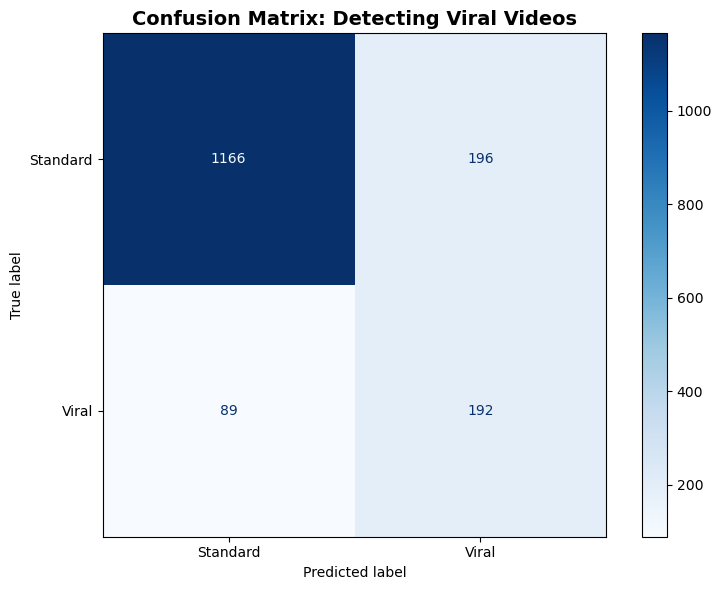

In [15]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Standard', 'Viral']
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix: Detecting Viral Videos', 
          fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

### 📝 What These Results Mean

- **Accuracy (82.65%)** is close to the baseline, meaning the model overall performs similarly to always predicting non-viral — but accuracy alone is misleading due to class imbalance.  
- **Precision (49.48%)** shows that about half of the videos the model labels as viral actually are viral.  
- **Recall (68.33%)** indicates the model catches most of the true viral videos, which is valuable since viral videos are the minority class.  

**Overall:**  
The classifier is *significantly better* than baseline at identifying viral videos, trading some precision for stronger recall. This means it's good at *finding* potential viral hits, even if some predictions are false positives.


## 7️⃣ 🔍 Predicted Viral Probabilities & Feature Importance

### 🎯 Getting Viral Probabilities
We extract the model’s predicted probability that each video in the test set is **viral** (class 1):

In [16]:
probabilities = clf.predict_proba(X_test)

# Extract just the "VIRAL" probabilities (column 1)
viral_probs = probabilities[:, 1]

# Convert to percentages
viral_probs_pct = viral_probs * 100

viral_probs_pct

array([15.74677962, 67.46039619, 18.66296778, ..., 19.08799736,
        5.28395822,  2.0794523 ])

### 🔎 Top Features Driving Virality

The chart below shows which features the Random Forest model relied on the most when predicting whether a video becomes viral. Higher bars indicate features that contributed more to the model’s decisions.


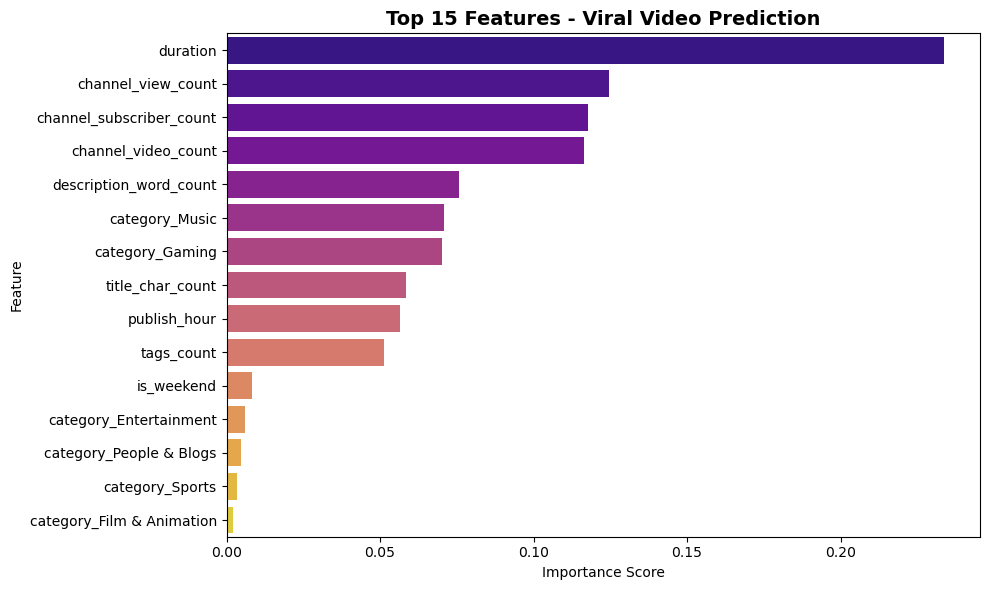

In [17]:
importance_df = pd.DataFrame({
    'Feature': model_columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='plasma', hue = 'Feature')
plt.title('Top 15 Features - Viral Video Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### 📝 Summary of Feature Importance Results

- **Duration** is the strongest predictor of virality.  
- Channel-level metrics (views, subscribers, total videos) also play a major role.  
- Text-related features like **description word count** and **title length** influence performance.  
- Certain categories (Music, Gaming, Entertainment) carry notable predictive value.  

Overall, the model relies on a mix of **video length**, **creator size**, and **content category** to judge whether a video is likely to go viral (1+ days).


In [18]:
# Save the final trained model object
joblib.dump(clf, '../models/viral_prediction_model.pkl')

# Save the column list
joblib.dump(model_columns, '../models/model_columns.pkl')

# Saves the fitted encoder object 
joblib.dump(encoder, '../models/category_encoder.pkl')

['../models/category_encoder.pkl']